In [1]:
"""
Pseudocode for NMSE COC

1. Import necessary packages.
2. Generate theoretical EPW and IAW spectra (S).
3. Fit S.
    3.1. Define NMSE COC.
    3.2. Generate initial EPW S'.
    3.3. Perform iterative fitting for EPW and extract parameters.
    3.4. Repeat previous 2 steps for IAW.
4. Save all required information to fit to hdf5 file (Not done here).

Order in which parameters will vary (Most senstiive to least sensitive):
Electrons: n -> temps -> p -> vds
Ions: vds -> p -> temps
"""

"\nPseudocode for NMSE COC\n\n1. Import necessary packages.\n2. Generate theoretical EPW and IAW spectra (S).\n3. Fit S.\n    3.1. Define NMSE COC.\n    3.2. Generate initial EPW S'.\n    3.3. Perform iterative fitting for EPW and extract parameters.\n    3.4. Repeat previous 2 steps for IAW.\n4. Save all required information to fit to hdf5 file (Not done here).\n\nOrder in which parameters will vary (Most senstiive to least sensitive):\nElectrons: n -> temps -> p -> vds\nIons: vds -> p -> temps\n"

# 1. Import Necessary Packages + Declare User Inputs

In [1]:
!pip install lmfit
!pip install git+https://github.com/BradynK/PlasmaPy2.git
!pip install numba
!pip install numba_scipy

  Cloning https://github.com/BradynK/PlasmaPy2.git to /private/var/folders/x1/n8g05lb95ds78kqv9nzxm5cm0000gn/T/pip-req-build-a562sbjo
  Running command git clone --filter=blob:none --quiet https://github.com/BradynK/PlasmaPy2.git /private/var/folders/x1/n8g05lb95ds78kqv9nzxm5cm0000gn/T/pip-req-build-a562sbjo
  Resolved https://github.com/BradynK/PlasmaPy2.git to commit 12ef7cb7f5fcc64644443fbb2149ac63c0766481
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numba_scipy-0.4.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached scipy-1.9.3.tar.gz (42.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [32 lines of output]
      + me

In [2]:
!pip install "xarray==2023.12.0"
!pip install imageio
!pip install opencv-python
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

%matplotlib inline
import numpy as np

from plasmapy.diagnostics import thomson2 as thomson

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import imageio
import time
import h5py
import cv2

import os
import shutil
import csv

import scipy as sp
from scipy import constants as sc
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy import interpolate

import astropy.units as u
from astropy.coordinates import spherical_to_cartesian
import pandas as pd


from lmfit import Parameters
from lmfit.models import VoigtModel
###


import torch
from torch import Tensor
import torch.nn.functional as F


import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import trange

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
# import warnings

from lmfit import Parameters

from plasmapy.formulary import Maxwellian_1D
#from plasmapy.diagnostics import thomson
from plasmapy.diagnostics import thomsonAD
from plasmapy.diagnostics import cpu_autodiff_thomson

import matplotlib.pyplot as plt
import astropy.constants as const

from scipy.special import expit, gamma
import random

import h5py

# Make all tensors float64 by default
torch.set_default_dtype(torch.float64)

Looking in indexes: https://download.pytorch.org/whl/cpu


In [3]:
# All surface level user inputs must be declared here

# Declare true plasma params (TPP)
# [n]: m^-3
# [T]: eV
# [vd]: m/s

# For ions
# H: 400 eV, 500 km/s, 90%
# C: 400 eV, 500 km/s, 10%, +5 ionization

n_true = 1.0e25 # m^-3

e_T1_true = 50. # eV
e_T2_true = 500.
e_T3_true = 50.
e_T4_true = 500.
e_T5_true = 50.
e_T6_true = 50. # eV
e_T7_true = 500.
e_T8_true = 50.
e_T9_true = 500.
e_T10_true = 50.


e_vd1_true = 0. # m/s
e_vd2_true = 5.0e5
e_vd3_true = 0.
e_vd4_true = 5.0e5
e_vd5_true = 0.
e_vd6_true = 0. # m/s
e_vd7_true = 5.0e5
e_vd8_true = 0.
e_vd9_true = 5.0e5
e_vd10_true = 0.


e_n1_true = 1/11
e_n2_true = 10/11
e_n3_true = 0.
e_n4_true = 0.
e_n5_true = 0.
e_n6_true = 0.
e_n7_true = 0.
e_n8_true = 0.
e_n9_true = 0.
e_n10_true = 0.


i0_T_true = 10.         #effective temperature of ions due to mass
i1_T_true = 500. 
i2_T_true = 500. 
i3_T_true = 10. 
i4_T_true = 500.
i5_T_true = 10.         #effective temperature of ions due to mass
i6_T_true = 500. 
i7_T_true = 500. 
i8_T_true = 10. 
i9_T_true = 500. 

i0_vd_true = 5e5
i1_vd_true = 0.
i2_vd_true = 5e5
i3_vd_true = 5e5
i4_vd_true = 0.
i5_vd_true = 5e5
i6_vd_true = 0.
i7_vd_true = 5e5
i8_vd_true = 5e5
i9_vd_true = 0.



i0_fract_true = 0.
i1_fract_true = 1/71
i2_fract_true = 10/71
i3_fract_true = 1-i1_fract_true-i2_fract_true
i4_fract_true = 0.
i5_fract_true = 0.
i6_fract_true = 0.
i7_fract_true = 0.
i8_fract_true = 0.
i9_fract_true = 0.


# Construct TPP as a dictionary of form: [n, e_T, e_p, e_vd, i0_vd, i0_p, i0_T]
TPP = {
    "n_true"       : n_true,
    "e_n1_true"    : e_n1_true,
    "e_n2_true"    : e_n2_true,
    "e_n3_true"    : e_n3_true,
    "e_n4_true"    : e_n4_true,
    "e_n5_true"    : e_n5_true,
    "e_n6_true"    : e_n6_true,
    "e_n7_true"    : e_n7_true,
    "e_n8_true"    : e_n8_true,
    "e_n9_true"    : e_n9_true,
    "e_n10_true"   : e_n10_true,
    "e_T1_true"    : e_T1_true,
    "e_T2_true"    : e_T2_true,
    "e_T3_true"    : e_T3_true,
    "e_T4_true"    : e_T4_true,
    "e_T5_true"    : e_T5_true,
    "e_T6_true"    : e_T6_true,
    "e_T7_true"    : e_T7_true,
    "e_T8_true"    : e_T8_true,
    "e_T9_true"    : e_T9_true,
    "e_T10_true"   : e_T10_true,
    "e_vd1_true"   : e_vd1_true,
    "e_vd2_true"   : e_vd2_true,
    "e_vd3_true"   : e_vd3_true,
    "e_vd4_true"   : e_vd4_true,
    "e_vd5_true"   : e_vd5_true,
    "e_vd6_true"   : e_vd6_true,
    "e_vd7_true"   : e_vd7_true,
    "e_vd8_true"   : e_vd8_true,
    "e_vd9_true"   : e_vd9_true,
    "e_vd10_true"  : e_vd10_true,
    "i0_fract_true": i0_fract_true,
    "i1_fract_true": i1_fract_true,
    "i2_fract_true": i2_fract_true,
    "i3_fract_true": i3_fract_true,
    "i4_fract_true": i4_fract_true,
    "i5_fract_true": i5_fract_true,
    "i6_fract_true": i6_fract_true,
    "i7_fract_true": i7_fract_true,
    "i8_fract_true": i8_fract_true,
    "i9_fract_true": i9_fract_true,
    "i0_vd_true"   : i0_vd_true,
    "i1_vd_true"   : i1_vd_true,
    "i2_vd_true"   : i2_vd_true,
    "i3_vd_true"   : i3_vd_true,
    "i4_vd_true"   : i4_vd_true,
    "i5_vd_true"   : i5_vd_true,
    "i6_vd_true"   : i6_vd_true,
    "i7_vd_true"   : i7_vd_true,
    "i8_vd_true"   : i8_vd_true,
    "i9_vd_true"   : i9_vd_true,
    "i0_T_true"    : i0_T_true,
    "i1_T_true"    : i1_T_true,
    "i2_T_true"    : i2_T_true,
    "i3_T_true"    : i3_T_true,
    "i4_T_true"    : i4_T_true,
    "i5_T_true"    : i5_T_true,
    "i6_T_true"    : i6_T_true,
    "i7_T_true"    : i7_T_true,
    "i8_T_true"    : i8_T_true,
    "i9_T_true"    : i9_T_true
}

# Keep track of number of EPW and IAW params
NUM_ELECTRON_PARAMS = 31
NUM_ION_PARAMS = 30  # Since we never fit i2_fract by itself
NUM_PARAMS = NUM_ELECTRON_PARAMS + NUM_ION_PARAMS

# Choose number of parameters to vary (Done in order: [n, e_n1, e_T2, e_T1, e_vd2, e_vd1, i1_fract, i0_fract, i2_vd, i1_vd, i0_vd])
NUM_FREE_PARAMS = NUM_PARAMS

"""
# Declare file path to write hdf5 file and keys for theoretical + best fit data
FILE_PATH = "/Users/vedang/Desktop/Plasma_Research/output_files/sg_file_test_dict.hdf5"
THEORETICAL_KEY = "theoretical_data"
BEST_FIT_KEY = "best_fit_data"
sg_file = h5py.File(FILE_PATH, "w")"""

# Declare cutoff criteria for spectra fitting here
# Defined as difference between consecutive iterations
EPW_CUTOFF_CRITERIA = 1e-8
IAW_CUTOFF_CRITERIA = EPW_CUTOFF_CRITERIA * 10

# Set a flag for minimum number of iterations
MIN_NUM_ITERS = 500

In [4]:
# Generate param keys automatically from TPP
param_keys = []
for key in TPP.keys():
    param_keys.append(key[:-len("_true")])

electron_param_keys = []
for key in param_keys[:NUM_ELECTRON_PARAMS]:
    if key == "n": electron_param_keys.append("ln_"+key)
    elif key[0] == "e":
        if "T" in key: electron_param_keys.append("ln_"+key)
        else: electron_param_keys.append(key)

    else: raise ValueError("Invalid param key entered, check TPP dictionary!")

ion_param_keys = []
for key in param_keys[NUM_ELECTRON_PARAMS:]:
    if key[0] != "i": raise ValueError("Invalid param key entered, check TPP dictionary!")
    elif "T" in key: ion_param_keys.append("ln_"+key)
    else:  ion_param_keys.append(key)

In [5]:
print(param_keys)
print(electron_param_keys)
print(ion_param_keys)

['n', 'e_n1', 'e_n2', 'e_n3', 'e_n4', 'e_n5', 'e_n6', 'e_n7', 'e_n8', 'e_n9', 'e_n10', 'e_T1', 'e_T2', 'e_T3', 'e_T4', 'e_T5', 'e_T6', 'e_T7', 'e_T8', 'e_T9', 'e_T10', 'e_vd1', 'e_vd2', 'e_vd3', 'e_vd4', 'e_vd5', 'e_vd6', 'e_vd7', 'e_vd8', 'e_vd9', 'e_vd10', 'i0_fract', 'i1_fract', 'i2_fract', 'i3_fract', 'i4_fract', 'i5_fract', 'i6_fract', 'i7_fract', 'i8_fract', 'i9_fract', 'i0_vd', 'i1_vd', 'i2_vd', 'i3_vd', 'i4_vd', 'i5_vd', 'i6_vd', 'i7_vd', 'i8_vd', 'i9_vd', 'i0_T', 'i1_T', 'i2_T', 'i3_T', 'i4_T', 'i5_T', 'i6_T', 'i7_T', 'i8_T', 'i9_T']
['ln_n', 'e_n1', 'e_n2', 'e_n3', 'e_n4', 'e_n5', 'e_n6', 'e_n7', 'e_n8', 'e_n9', 'e_n10', 'ln_e_T1', 'ln_e_T2', 'ln_e_T3', 'ln_e_T4', 'ln_e_T5', 'ln_e_T6', 'ln_e_T7', 'ln_e_T8', 'ln_e_T9', 'ln_e_T10', 'e_vd1', 'e_vd2', 'e_vd3', 'e_vd4', 'e_vd5', 'e_vd6', 'e_vd7', 'e_vd8', 'e_vd9', 'e_vd10']
['i0_fract', 'i1_fract', 'i2_fract', 'i3_fract', 'i4_fract', 'i5_fract', 'i6_fract', 'i7_fract', 'i8_fract', 'i9_fract', 'i0_vd', 'i1_vd', 'i2_vd', 'i3_vd', 'i

# 2. Generate Theoretical EPW and IAW Spectra (S)

In [6]:
# Generate Super-Gaussian VDFs
def maxwellian_e(v, T, vd):
    T_K = T * 11605
    vth = np.sqrt(2 * 1.5156e7 * T_K)
    exp_term = -(v - vd) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

def bimaxwellian_e(v, T1, vd1, T2, vd2, n1):
    return n1 * maxwellian_e(v, T1, vd1) + (1 - n1) * maxwellian_e(v, T2, vd2)

def maxwellian_H(v, T, vd):
    T_K = T * 11605
    vth = np.sqrt(2 * 1.5156e7 * T_K / 1836)
    exp_term = -(v - vd) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

def maxwellian_C(v, T, vd):
    T_K = T * 11605
    vth = np.sqrt(2 * 1.5156e7 * T_K / 1836 / 12)
    exp_term = -(v - vd) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

notch = np.array([520, 540])

In [7]:
ve = np.linspace(-5e7, 5e7, 500)
vi = np.linspace(-2e6, 2e6, 500)

n_true = 1.0e25

e_T1_true = 50
e_T2_true = 500
e1_vd_true = 0
e_vd2_true = 5e5


i0_T_true = 400
i0_vd_true = 5e5
i1_T_true = 400
i1_vd_true = 5e5


In [8]:
# Kwargs to pass to spectral_density_arbdist() function
probe_wavelength = 532 * u.nm
epw_wavelengths = np.linspace(probe_wavelength.value - 100, probe_wavelength.value + 100, num=200) * u.nm
iaw_wavelengths = np.linspace(probe_wavelength.value - 3, probe_wavelength.value + 3, num=200) * u.nm

ve = np.linspace(-5e7, 5e7, 500)
vi = np.linspace(-2e6, 2e6, 500)

fe_in = bimaxwellian_e(ve, 50, 0, 500, 5e5, 1/11)
fH_in = maxwellian_H(vi, 400, 5.0e5)
fC_in = maxwellian_C(vi, 400, 5.0e5)
n = n_true * 1e-6   # Convert density from m^-3 to cm^-3

In [9]:
# Generate theoretical spectra
alpha, epw_target = thomsonAD.spectral_density_arbdist(
    wavelengths = epw_wavelengths,
    notches = [notch] * u.nm,
    probe_wavelength = probe_wavelength,
    e_velocity_axes = [ve, ve] * u.m / u.s,
    i_velocity_axes = [vi, vi] * u.m / u.s,
    efn = [fe_in] * u.s / u.m,
    ifn = [fH_in, fC_in] * u.s / u.m,
    n = n * u.cm ** -3,
    scattered_power = True,
    ion_species = ['p', 'C-12 5+'],
    ifract = [ 9/10, 1/10]
)

alpha, iaw_target = thomsonAD.spectral_density_arbdist(
    wavelengths = iaw_wavelengths,
    probe_wavelength = probe_wavelength,
    e_velocity_axes = [ve] * u.m / u.s,
    i_velocity_axes = [vi, vi] * u.m / u.s,
    efn = [fe_in] * u.s / u.m,
    ifn = [fH_in, fC_in] * u.s / u.m,
    n = n * u.cm ** -3,
    scattered_power = True,
    ion_species = ['p', 'C-12 5+'],
    ifract = [9/10, 1/10]
)

# Make some noise
epw_target += np.random.normal(loc = 0, scale = 0.05 * max(epw_target), size = len(epw_wavelengths))
iaw_target += np.random.normal(loc = 0, scale = 0.05 * max(iaw_target), size = len(iaw_wavelengths))

# Convert 'em to tensors
epw_target = torch.from_numpy(epw_target)
iaw_target = torch.from_numpy(iaw_target)

# Statically define sum of theoretical spectra to be used in loss function
epw_sum = torch.sum(torch.square(epw_target))
iaw_sum = torch.sum(torch.square(iaw_target))

In [10]:
#print("EPW S:", epw_target)
#print("IAW S:", iaw_target)

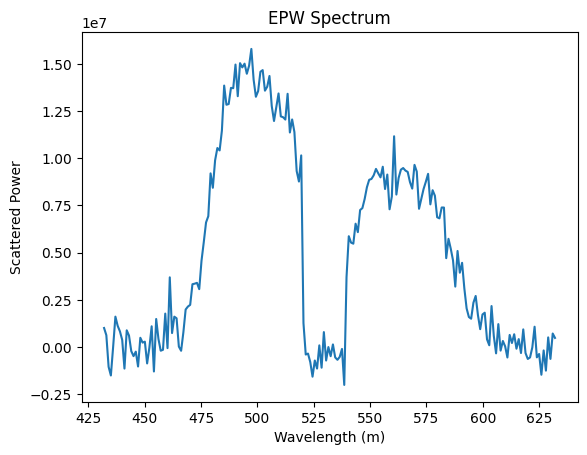

In [11]:
# Plot EPW spectrum
plt.plot(epw_wavelengths, epw_target.numpy())
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("EPW Spectrum")
plt.show()

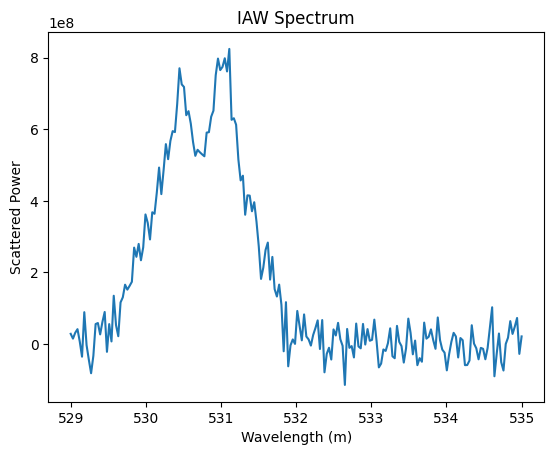

In [12]:
# Plot IAW spectrum
plt.plot(iaw_wavelengths, iaw_target.numpy())
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("IAW Spectrum")
plt.show()

import matplotlib.pyplot as plt

# ---- Electron VDF: True vs Initial Guess ----
guess_e = sum_of_maxwellians_TORCH(
    e_velocity_axis_TORCH,
    torch.tensor(user_guesses["ln_e_T1"]), user_guesses["e_vd1"],
    torch.tensor(user_guesses["ln_e_T2"]), user_guesses["e_vd2"],
    torch.tensor(user_guesses["ln_e_T3"]), user_guesses["e_vd3"],
    torch.tensor(user_guesses["ln_e_T4"]), user_guesses["e_vd4"],
    torch.tensor(user_guesses["ln_e_T5"]), user_guesses["e_vd5"],
    torch.tensor(user_guesses["ln_e_T6"]), user_guesses["e_vd6"],
    torch.tensor(user_guesses["ln_e_T7"]), user_guesses["e_vd7"],
    torch.tensor(user_guesses["ln_e_T8"]), user_guesses["e_vd8"],
    torch.tensor(user_guesses["ln_e_T9"]), user_guesses["e_vd9"],
    torch.tensor(user_guesses["ln_e_T10"]), user_guesses["e_vd10"],
    user_guesses["e_n1"], user_guesses["e_n2"], user_guesses["e_n3"], user_guesses["e_n4"], user_guesses["e_n5"],
    user_guesses["e_n6"], user_guesses["e_n7"], user_guesses["e_n8"], user_guesses["e_n9"], user_guesses["e_n10"]
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(e_velocity_axis_TORCH, fe_in, label='True Electron VDF')
plt.plot(e_velocity_axis_TORCH, guess_e.detach().numpy(), label='Initial Guess')
plt.xlabel("Velocity (m/s)")
plt.ylabel("f_e(v)")
plt.title("Electron VDF")
plt.legend()

# ---- Ion VDF: True vs Initial Guess ----
"guess_i = sum_of_maxwellians_TORCH(
    i_velocity_axis_TORCH,
    torch.exp(torch.tensor(user_guesses["ln_i0_T"])), user_guesses["i0_vd"],
    torch.exp(torch.tensor(user_guesses["ln_i1_T"])), user_guesses["i1_vd"],
    torch.exp(torch.tensor(user_guesses["ln_i2_T"])), user_guesses["i2_vd"],
    torch.exp(torch.tensor(user_guesses["ln_i3_T"])), user_guesses["i3_vd"],
    torch.exp(torch.tensor(user_guesses["ln_i4_T"])), user_guesses["i4_vd"],
    torch.exp(torch.tensor(user_guesses["ln_i5_T"])), user_guesses["i5_vd"],
    torch.exp(torch.tensor(user_guesses["ln_i6_T"])), user_guesses["i6_vd"],
    torch.exp(torch.tensor(user_guesses["ln_i7_T"])), user_guesses["i7_vd"],
    torch.exp(torch.tensor(user_guesses["ln_i8_T"])), user_guesses["i8_vd"],
    torch.exp(torch.tensor(user_guesses["ln_i9_T"])), user_guesses["i9_vd"],
    user_guesses["i0_fract"], user_guesses["i1_fract"], user_guesses["i2_fract"], user_guesses["i3_fract"], user_guesses["i4_fract"],
    user_guesses["i5_fract"], user_guesses["i6_fract"], user_guesses["i7_fract"], user_guesses["i8_fract"], user_guesses["i9_fract"]
)






_, Skw_arbdist_epw = cpu_autodiff_thomson.spectral_density_arbdist(
    epw_wavelengths_TORCH,
    probe_wavelength_TORCH,
    e_velocity_axes_TORCH,
    i_velocity_axes_TORCH,
    guess_e,
    guess_i,
    derivative_matrices,
    torch.exp(electron_params["ln_n"]),
    epw_notches,
    efract_TORCH,
    ifract_TORCH,
    ion_species_TORCH,
    probe_vec_TORCH,
    scatter_vec_TORCH,
    scattered_power_TORCH,
    inner_range=0.1,
    inner_frac=0.8,
    )

_, Skw_arbdist_iaw = cpu_autodiff_thomson.spectral_density_arbdist(
    epw_wavelengths_TORCH,
    probe_wavelength_TORCH,
    e_velocity_axes_TORCH,
    i_velocity_axes_TORCH,
    guess_e,
    guess_i,
    derivative_matrices,
    torch.exp(electron_params["ln_n"]),
    epw_notches,
    efract_TORCH,
    ifract_TORCH,
    ion_species_TORCH,
    probe_vec_TORCH,
    scatter_vec_TORCH,
    scattered_power_TORCH,
    inner_range=0.1,
    inner_frac=0.8,
    )




plt.subplot(1, 2, 2)
plt.plot(i_velocity_axis_TORCH, fH_in, label='True Ion VDF')
plt.plot(i_velocity_axis_TORCH, guess_i.detach().numpy(), label='Initial Guess')
plt.xlabel("Velocity (m/s)")
plt.ylabel("f_i(v)")
plt.title("Ion VDF")
plt.legend()
plt.tight_layout()
plt.show()


# ---- Scattered Power Spectrum: EPW and IAW ----
plt.figure(figsize=(10, 4))
plt.plot(epw_wavelengths_TORCH.numpy(), Skw_arbdist_epw.detach().numpy(), label='EPW Guess')
plt.plot(iaw_wavelengths_TORCH.numpy(), Skw_arbdist_iaw.detach().numpy(), label='IAW Guess')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Scattered Power")
plt.title("Scattered Spectra: EPW and IAW")
plt.legend()
plt.tight_layout()
plt.show()"

# 3. Fit S

Parameters to optimize: 7
1. Electron velocities (1), ion velocities (1)
2. Electron temperatures (1), ion temperatures (1)
3. Electron p (1), ion p (1)
4. Density (1)

/var/folders/x1/n8g05lb95ds78kqv9nzxm5cm0000gn/T/ipykernel_89202/3060520448.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vth = torch.sqrt(torch.tensor(2 * 1.5156e7 * T_K))


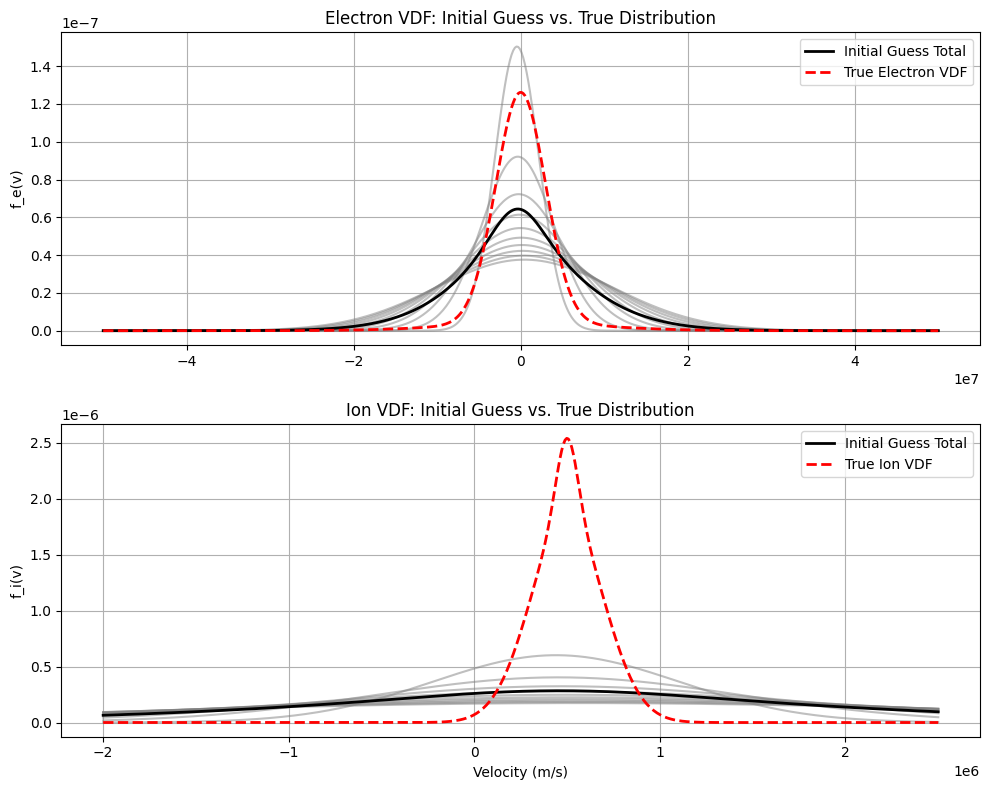

In [13]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------
# STEP 1: Define user_guesses dictionary
# --------------------------------------------

user_guesses = {
    "ln_n": 1.0e19,

    # --- Electron Maxwellians ---
    "e_n1": 0.10, "e_n2": 0.10, "e_n3": 0.10, "e_n4": 0.10, "e_n5": 0.10,
    "e_n6": 0.10, "e_n7": 0.10, "e_n8": 0.10, "e_n9": 0.10, "e_n10": 0.10,

    "ln_e_T1": 40.0, "ln_e_T2": 106.6667, "ln_e_T3": 173.3333, "ln_e_T4": 240.0, "ln_e_T5": 306.6667,
    "ln_e_T6": 373.3333, "ln_e_T7": 440.0, "ln_e_T8": 506.6667, "ln_e_T9": 573.3333, "ln_e_T10": 640.0,

    "e_vd1": -450000.0, "e_vd2": -350000.0, "e_vd3": -250000.0, "e_vd4": -150000.0, "e_vd5": -50000.0,
    "e_vd6":  50000.0,  "e_vd7": 150000.0,  "e_vd8": 250000.0,  "e_vd9": 350000.0,  "e_vd10": 450000.0,

    # --- Ion Maxwellians ---
    "i0_fract": 0.10, "i1_fract": 0.10, "i2_fract": 0.10, "i3_fract": 0.10, "i4_fract": 0.10,
    "i5_fract": 0.10, "i6_fract": 0.10, "i7_fract": 0.10, "i8_fract": 0.10, "i9_fract": 0.10,

    "i0_vd": 440000.0, "i1_vd": 453333.3, "i2_vd": 466666.7, "i3_vd": 480000.0, "i4_vd": 493333.3,
    "i5_vd": 506666.7, "i6_vd": 520000.0, "i7_vd": 533333.3, "i8_vd": 546666.7, "i9_vd": 560000.0,

    "ln_i0_T": 2.5, "ln_i1_T": 5.5556, "ln_i2_T": 8.6111, "ln_i3_T": 11.6667, "ln_i4_T": 14.7222,
    "ln_i5_T": 17.7778, "ln_i6_T": 20.8333, "ln_i7_T": 23.8889, "ln_i8_T": 26.9444, "ln_i9_T": 30.0,
}






# --------------------------------------------
# STEP 2: Extract parameters from user_guesses
# --------------------------------------------
e_Ts = torch.tensor([user_guesses[f"ln_e_T{i}"] for i in range(1, 11)])
e_vds = torch.tensor([user_guesses[f"e_vd{i}"] for i in range(1, 11)])
e_ns = [torch.tensor(user_guesses[f"e_n{i}"]) for i in range(1, 11)]

i_Ts = torch.tensor([user_guesses[f"ln_i{i}_T"] for i in range(10)])
i_vds = torch.tensor([user_guesses[f"i{i}_vd"] for i in range(10)])
i_ns = [torch.tensor(user_guesses[f"i{i}_fract"]) for i in range(10)]

# --------------------------------------------
# STEP 3: Velocity grids
# --------------------------------------------
ve = torch.linspace(-5e7, 5e7, 500)
vi = torch.linspace(-2e6, 2.5e6, 500)

# --------------------------------------------
# STEP 4: Define true VDFs (Torch)
# --------------------------------------------
def maxwellian_H(v, T, vd):
    T_K = T * 11605
    vth = torch.sqrt(torch.tensor(2 * 1.5156e7 * T_K / 1836.0))
    exp_term = -(v - vd) ** 2 / (vth ** 2)
    return torch.exp(exp_term) / torch.sqrt(torch.tensor(np.pi) * vth ** 2)

def maxwellian_C(v, T, vd):
    T_K = T * 11605
    vth = torch.sqrt(torch.tensor(2 * 1.5156e7 * T_K / (1836.0 * 12)))
    exp_term = -(v - vd) ** 2 / (vth ** 2)
    return torch.exp(exp_term) / torch.sqrt(torch.tensor(np.pi) * vth ** 2)

def bimaxwellian_e_torch(v, T1, vd1, T2, vd2, f2_frac):
    f1_frac = 1.0 - f2_frac
    T1_K = T1 * 11605
    T2_K = T2 * 11605
    vth1 = torch.sqrt(torch.tensor(2 * 1.5156e7 * T1_K))
    vth2 = torch.sqrt(torch.tensor(2 * 1.5156e7 * T2_K))
    f1 = f1_frac * torch.exp(-((v - vd1) ** 2) / vth1 ** 2) / torch.sqrt(torch.tensor(np.pi) * vth1 ** 2)
    f2 = f2_frac * torch.exp(-((v - vd2) ** 2) / vth2 ** 2) / torch.sqrt(torch.tensor(np.pi) * vth2 ** 2)
    return f1 + f2

fH = maxwellian_H(vi, 400, 5.0e5)
fC = maxwellian_C(vi, 400, 5.0e5)
fi_true = (9/10) * fH + (1/10) * fC
fe_true = bimaxwellian_e_torch(ve, 50, 0.0, 500, 5e5, 1/11)

# --------------------------------------------
# STEP 5: Superposition Functions
# --------------------------------------------
def general_maxwellian(v, T, vd):
    T_K = T * 11605
    vth = torch.sqrt(torch.tensor(2 * 1.5156e7 * T_K))
    exp_term = -1. * (v - vd) ** 2 / vth ** 2
    return torch.exp(exp_term) / torch.sqrt(torch.tensor(np.pi) * vth ** 2)

def sum_of_maxwellians_TORCH(v, Ts, vds, ns):
    maxwellians = [general_maxwellian(v, T, vd) for T, vd in zip(Ts, vds)]
    raw_weights = torch.stack(ns)
    weights = F.relu(raw_weights)
    weights = weights / weights.sum()
    return sum(w * m for w, m in zip(weights, maxwellians)), maxwellians, weights

# --------------------------------------------
# STEP 6: Evaluate initial guess distributions
# --------------------------------------------
fe_total, fe_components, _ = sum_of_maxwellians_TORCH(ve, e_Ts, e_vds, e_ns)
fi_total, fi_components, _ = sum_of_maxwellians_TORCH(vi, i_Ts, i_vds, i_ns)

# --------------------------------------------
# STEP 7: Plotting
# --------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Electrons
axes[0].set_title("Electron VDF: Initial Guess vs. True Distribution")
for f_i in fe_components:
    axes[0].plot(ve.numpy(), f_i.detach().numpy(), color='gray', alpha=0.5)
axes[0].plot(ve.numpy(), fe_total.detach().numpy(), 'k-', lw=2, label="Initial Guess Total")
axes[0].plot(ve.numpy(), fe_true.detach().numpy(), 'r--', lw=2, label="True Electron VDF")
axes[0].legend(); axes[0].set_ylabel("f_e(v)"); axes[0].grid(True)

# Ions
axes[1].set_title("Ion VDF: Initial Guess vs. True Distribution")
for f_i in fi_components:
    axes[1].plot(vi.numpy(), f_i.detach().numpy(), color='gray', alpha=0.5)
axes[1].plot(vi.numpy(), fi_total.detach().numpy(), 'k-', lw=2, label="Initial Guess Total")
axes[1].plot(vi.numpy(), fi_true.detach().numpy(), 'r--', lw=2, label="True Ion VDF")
axes[1].legend(); axes[1].set_ylabel("f_i(v)"); axes[1].set_xlabel("Velocity (m/s)"); axes[1].grid(True)

plt.tight_layout()
plt.show()


In [14]:

user_guesses = {
    "ln_n": 1.0e19,

    # --- Electron Maxwellians ---
    "e_n1": 0.10, "e_n2": 0.10, "e_n3": 0.10, "e_n4": 0.10, "e_n5": 0.10,
    "e_n6": 0.10, "e_n7": 0.10, "e_n8": 0.10, "e_n9": 0.10, "e_n10": 0.10,

    "ln_e_T1": 40.0, "ln_e_T2": 106.6667, "ln_e_T3": 173.3333, "ln_e_T4": 240.0, "ln_e_T5": 306.6667,
    "ln_e_T6": 373.3333, "ln_e_T7": 440.0, "ln_e_T8": 506.6667, "ln_e_T9": 573.3333, "ln_e_T10": 640.0,

    "e_vd1": -450000.0, "e_vd2": -350000.0, "e_vd3": -250000.0, "e_vd4": -150000.0, "e_vd5": -50000.0,
    "e_vd6":  50000.0,  "e_vd7": 150000.0,  "e_vd8": 250000.0,  "e_vd9": 350000.0,  "e_vd10": 450000.0,

    # --- Ion Maxwellians ---
    "i0_fract": 0.10, "i1_fract": 0.10, "i2_fract": 0.10, "i3_fract": 0.10, "i4_fract": 0.10,
    "i5_fract": 0.10, "i6_fract": 0.10, "i7_fract": 0.10, "i8_fract": 0.10, "i9_fract": 0.10,

    "i0_vd": 440000.0, "i1_vd": 453333.3, "i2_vd": 466666.7, "i3_vd": 480000.0, "i4_vd": 493333.3,
    "i5_vd": 506666.7, "i6_vd": 520000.0, "i7_vd": 533333.3, "i8_vd": 546666.7, "i9_vd": 560000.0,

    "ln_i0_T": 2.5, "ln_i1_T": 5.5556, "ln_i2_T": 8.6111, "ln_i3_T": 11.6667, "ln_i4_T": 14.7222,
    "ln_i5_T": 17.7778, "ln_i6_T": 20.8333, "ln_i7_T": 23.8889, "ln_i8_T": 26.9444, "ln_i9_T": 30.0,
}

















# Initialize guesses
init_guesses = {}

# Get list of actual fitting parameter names
fit_keys = electron_param_keys + ion_param_keys

# Fill guesses for free parameters
if NUM_FREE_PARAMS == NUM_PARAMS:
    for key in fit_keys:
        if key not in user_guesses:
            raise ValueError(f"Missing user guess for: {key}")
        init_guesses[key] = user_guesses[key]
else:
    for key in fit_keys[:NUM_FREE_PARAMS]:
        if key not in user_guesses:
            raise ValueError(f"Missing user guess for: {key}")
        init_guesses[key] = user_guesses[key]

    # Fill fixed parameters using true values from TPP
    for key in fit_keys[NUM_FREE_PARAMS:]:
        raw_key = key.replace("ln_", "")
        true_val = TPP[f"{raw_key}_true"]
        init_guesses[key] = np.log(true_val) if "ln_" in key else true_val









init_guesses_keys = list(init_guesses.keys())

# Separate electron and ion params into their own dictionaries
electron_params = {}
for i in range(NUM_ELECTRON_PARAMS):
    if "ln" in electron_param_keys[i]: electron_params[electron_param_keys[i]] = torch.log(torch.tensor([init_guesses[init_guesses_keys[i]]]))
    else: electron_params[electron_param_keys[i]] = torch.tensor([init_guesses[init_guesses_keys[i]]])

print(electron_params)

ion_params = {}
for i in range(NUM_ION_PARAMS):
    if "ln" in ion_param_keys[i]: ion_params[ion_param_keys[i]] = torch.log(torch.tensor([init_guesses[init_guesses_keys[NUM_ELECTRON_PARAMS+i]]]))
    else: ion_params[ion_param_keys[i]] = torch.tensor([init_guesses[init_guesses_keys[NUM_ELECTRON_PARAMS+i]]])

print(ion_params)








# Attach gradients to plasma params depending on number of free params set
if NUM_FREE_PARAMS >= NUM_ELECTRON_PARAMS:
    for param in electron_params: electron_params[param].requires_grad=True
else:
    for i in range(NUM_FREE_PARAMS):
        electron_params[electron_param_keys[i]].requires_grad=True















{'ln_n': tensor([43.7491]), 'e_n1': tensor([0.1000]), 'e_n2': tensor([0.1000]), 'e_n3': tensor([0.1000]), 'e_n4': tensor([0.1000]), 'e_n5': tensor([0.1000]), 'e_n6': tensor([0.1000]), 'e_n7': tensor([0.1000]), 'e_n8': tensor([0.1000]), 'e_n9': tensor([0.1000]), 'e_n10': tensor([0.1000]), 'ln_e_T1': tensor([3.6889]), 'ln_e_T2': tensor([4.6697]), 'ln_e_T3': tensor([5.1552]), 'ln_e_T4': tensor([5.4806]), 'ln_e_T5': tensor([5.7258]), 'ln_e_T6': tensor([5.9225]), 'ln_e_T7': tensor([6.0868]), 'ln_e_T8': tensor([6.2279]), 'ln_e_T9': tensor([6.3515]), 'ln_e_T10': tensor([6.4615]), 'e_vd1': tensor([-450000.]), 'e_vd2': tensor([-350000.]), 'e_vd3': tensor([-250000.]), 'e_vd4': tensor([-150000.]), 'e_vd5': tensor([-50000.]), 'e_vd6': tensor([50000.]), 'e_vd7': tensor([150000.]), 'e_vd8': tensor([250000.]), 'e_vd9': tensor([350000.]), 'e_vd10': tensor([450000.])}
{'i0_fract': tensor([0.1000]), 'i1_fract': tensor([0.1000]), 'i2_fract': tensor([0.1000]), 'i3_fract': tensor([0.1000]), 'i4_fract': ten

# Trying to Plot (Check if guess and maybe add Maxwellians)

## 3.1. Define NMSE Loss Function

In [15]:
def dist_score(Skw_Prime, Skw):
    mse = F.mse_loss(Skw_Prime, Skw)
    loss = (mse/torch.var(Skw))*100
    loss.backward(retain_graph=True)
    return loss

def nmse(Skw_Prime, Skw):
    mse = F.mse_loss(Skw_Prime, Skw)
    norm_mse = (mse/torch.var(Skw))*100
    return norm_mse

def error(observed_val, true_val):
    return 100*(np.abs((observed_val-true_val))/true_val)

## 3.2. Generate Initial EPW S'

In [16]:
# Declare S(k,w) arguments to pass to forward model
probe_wavelength_TORCH = 532 # nm

# Hard convert wavelengths to nm to match Bryan's code
epw_wavelengths_TORCH = torch.linspace(probe_wavelength_TORCH - 100, probe_wavelength_TORCH + 100, steps=200, dtype=torch.float64) * 1e-9  # * u.nm
iaw_wavelengths_TORCH = torch.linspace(probe_wavelength_TORCH - 3, probe_wavelength_TORCH + 3, steps=200, dtype=torch.float64) * 1e-9 # * u.nm
ve_TORCH = torch.linspace(-5e7, 5e7, 500, dtype=torch.float64)
vH_TORCH = torch.linspace(-2e6, 2e6, 500, dtype=torch.float64)

probe_wavelength_TORCH *= 1e-9 # u.nm

epw_notch = torch.tensor([[520, 540]])
epw_notches = epw_notch * 1e-9
iaw_notch = None

e_velocity_axis_TORCH = ve_TORCH.clone().detach()
e_velocity_axes_TORCH = [e_velocity_axis_TORCH]

i_velocity_axis_TORCH = vH_TORCH.clone().detach()
i_velocity_axes_TORCH = [i_velocity_axis_TORCH]

efract_TORCH = torch.tensor([1.], dtype=torch.float64)
ifract_TORCH = torch.tensor([1.], dtype=torch.float64)

probe_vec_TORCH = torch.tensor([1, 0, 0], dtype=torch.float64)
scatter_vec_TORCH = torch.tensor([0, 1, 0], dtype=torch.float64)
scattered_power_TORCH = True
ion_species_TORCH = ["p"]

In [17]:
# Construct derivative matrices to perform first order and second order differentiation

# Computes derivatives of order 1
finDiffMat1 = torch.zeros(len(ve_TORCH), len(ve_TORCH))

# Forward difference elements
finDiffMat1[0][0] = -25./12.
finDiffMat1[0][1] = 4.
finDiffMat1[0][2] = -3.
finDiffMat1[0][3] = 4./3.
finDiffMat1[0][4] = -1./4.

finDiffMat1[1][1] = -25./12.
finDiffMat1[1][2] = 4.
finDiffMat1[1][3] = -3.
finDiffMat1[1][4] = 4./3.
finDiffMat1[1][5] = -1./4.

# Backward difference elements
finDiffMat1[-1][-1] = 25./12.
finDiffMat1[-1][-2] = -4.
finDiffMat1[-1][-3] = 3.
finDiffMat1[-1][-4] = -4./3.
finDiffMat1[-1][-5] = 1./4.

finDiffMat1[-2][-2] = 25./12.
finDiffMat1[-2][-3] = -4.
finDiffMat1[-2][-4] = 3.
finDiffMat1[-2][-5] = -4./3.
finDiffMat1[-2][-6] = 1./4.

# Centered difference elements
for i in range(2, len(finDiffMat1)-2):
    finDiffMat1[i][i-2] = 1./12.
    finDiffMat1[i][i-1] = -8./12.
    finDiffMat1[i][i] = 0.
    finDiffMat1[i][i+1] = 8./12.
    finDiffMat1[i][i+2] = -1./12.

# Computes derivatives of order 2
finDiffMat2 = torch.zeros(len(ve_TORCH), len(ve_TORCH))

# Forward difference elements
finDiffMat2[0][0] = 15./4.
finDiffMat2[0][1] = -77./6.
finDiffMat2[0][2] = 107./6.
finDiffMat2[0][3] = -13.
finDiffMat2[0][4] = 61./12.
finDiffMat2[0][5] = -5./6.

finDiffMat2[1][1] = 15./4.
finDiffMat2[1][2] = -77./6.
finDiffMat2[1][3] = 107./6.
finDiffMat2[1][4] = -13.
finDiffMat2[1][5] = 61./12.
finDiffMat2[1][6] = -5./6.

# Backward difference elements
finDiffMat2[-1][-1] = 15./4.
finDiffMat2[-1][-2] = -77./6.
finDiffMat2[-1][-3] = 107./6.
finDiffMat2[-1][-4] = -13.
finDiffMat2[-1][-5] = 61./12.
finDiffMat2[-1][-6] = -5./6.

finDiffMat2[-2][-2] = 15./4.
finDiffMat2[-2][-3] = -77./6.
finDiffMat2[-2][-4] = 107./6.
finDiffMat2[-2][-5] = -13.
finDiffMat2[-2][-6] = 61./12.
finDiffMat2[-2][-7] = -5./6.

# Centered difference elements
for i in range(2, len(finDiffMat2)-2):
    finDiffMat2[i][i-2] = -1./12.
    finDiffMat2[i][i-1] = 4./3.
    finDiffMat2[i][i] = -5./2.
    finDiffMat2[i][i+1] = 4./3.
    finDiffMat2[i][i+2] = -1./12.

derivative_matrices = [finDiffMat1, finDiffMat2]

# Define Sum of Maxwellians for Fitting Process

In [18]:
import torch
import torch.nn.functional as F

def general_maxwellian(v, T, vd):
    T_K = T * 11605
    vth = torch.sqrt(2 * 1.5156e7 * T_K)
    exp_term = -1. * torch.square(v - vd) / torch.square(vth)
    return torch.exp(exp_term) / torch.sqrt(torch.pi * torch.square(vth))

# Reuse general_maxwellian for all 10 components
def maxwellian_1_TORCH(v, T1, vd1): return general_maxwellian(v, T1, vd1)
def maxwellian_2_TORCH(v, T2, vd2): return general_maxwellian(v, T2, vd2)
def maxwellian_3_TORCH(v, T3, vd3): return general_maxwellian(v, T3, vd3)
def maxwellian_4_TORCH(v, T4, vd4): return general_maxwellian(v, T4, vd4)
def maxwellian_5_TORCH(v, T5, vd5): return general_maxwellian(v, T5, vd5)
def maxwellian_6_TORCH(v, T6, vd6): return general_maxwellian(v, T6, vd6)
def maxwellian_7_TORCH(v, T7, vd7): return general_maxwellian(v, T7, vd7)
def maxwellian_8_TORCH(v, T8, vd8): return general_maxwellian(v, T8, vd8)
def maxwellian_9_TORCH(v, T9, vd9): return general_maxwellian(v, T9, vd9)
def maxwellian_10_TORCH(v, T10, vd10): return general_maxwellian(v, T10, vd10)

def sum_of_maxwellians_TORCH(
    v, T1, vd1, T2, vd2, T3, vd3, T4, vd4, T5, vd5, 
    T6, vd6, T7, vd7, T8, vd8, T9, vd9, T10, vd10, 
    n1, n2, n3, n4, n5, n6, n7, n8, n9, n10
):
    maxwellians = [
        maxwellian_1_TORCH(v, T1, vd1),
        maxwellian_2_TORCH(v, T2, vd2),
        maxwellian_3_TORCH(v, T3, vd3),
        maxwellian_4_TORCH(v, T4, vd4),
        maxwellian_5_TORCH(v, T5, vd5),
        maxwellian_6_TORCH(v, T6, vd6),
        maxwellian_7_TORCH(v, T7, vd7),
        maxwellian_8_TORCH(v, T8, vd8),
        maxwellian_9_TORCH(v, T9, vd9),
        maxwellian_10_TORCH(v, T10, vd10),
    ]

    # Stack and ReLU clip all weights
    raw_weights = torch.stack([n1, n2, n3, n4, n5, n6, n7, n8, n9, n10])
    weights = F.relu(raw_weights)

    total_weight = weights.sum()
    if total_weight.item() == 0.0:
        raise ValueError("All Maxwellian weights are zero.")

    weights = weights / total_weight  # Normalize to sum to one

    weighted_sum = sum(w * m for w, m in zip(weights, maxwellians))
    return weighted_sum


In [19]:
# Call forward model function to generate initial EPW S'
# Call forward model function to generate initial S'
efn = sum_of_maxwellians_TORCH(e_velocity_axis_TORCH, torch.exp(electron_params["ln_e_T1"]), electron_params["e_vd1"],
                           torch.exp(electron_params["ln_e_T2"]), electron_params["e_vd2"], torch.exp(electron_params["ln_e_T3"]),
                           electron_params["e_vd3"], torch.exp(electron_params["ln_e_T4"]), electron_params["e_vd4"], torch.exp(electron_params["ln_e_T5"]),
                           electron_params["e_vd5"], torch.exp(electron_params["ln_e_T6"]), electron_params["e_vd6"], torch.exp(electron_params["ln_e_T7"]),
                           electron_params["e_vd7"], torch.exp(electron_params["ln_e_T8"]), electron_params["e_vd8"], torch.exp(electron_params["ln_e_T9"]),
                           electron_params["e_vd9"], torch.exp(electron_params["ln_e_T10"]), electron_params["e_vd10"],
                           electron_params["e_n1"], electron_params["e_n2"], electron_params["e_n3"], electron_params["e_n4"], electron_params["e_n5"],
                           electron_params["e_n6"], electron_params["e_n7"], electron_params["e_n8"], electron_params["e_n9"], electron_params["e_n10"])

#fH_ambient = maxwellian_H_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i0_T"]), ion_params["i0_vd"])
#fH_piston = maxwellian_H_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i1_T"]), ion_params["i1_vd"])
#fC_piston = maxwellian_C_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i2_T"]), ion_params["i2_vd"])

ifn = sum_of_maxwellians_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i0_T"]), ion_params["i0_vd"], torch.exp(ion_params["ln_i1_T"]),
                               ion_params["i1_vd"], torch.exp(ion_params["ln_i2_T"]), ion_params["i2_vd"], torch.exp(ion_params["ln_i3_T"]), ion_params["i3_vd"],
                               torch.exp(ion_params["ln_i4_T"]), ion_params["i4_vd"], torch.exp(ion_params["ln_i5_T"]), ion_params["i5_vd"], torch.exp(ion_params["ln_i6_T"]),
                               ion_params["i6_vd"], torch.exp(ion_params["ln_i7_T"]), ion_params["i7_vd"], torch.exp(ion_params["ln_i8_T"]), ion_params["i8_vd"],
                               torch.exp(ion_params["ln_i9_T"]), ion_params["i9_vd"], ion_params["i0_fract"],
                               ion_params["i1_fract"], ion_params["i2_fract"], ion_params["i3_fract"], ion_params["i4_fract"], ion_params["i5_fract"], ion_params["i6_fract"],
                               ion_params["i7_fract"], ion_params["i8_fract"], ion_params["i9_fract"])

efn_epw = [efn]
ifn_epw = [ifn]

# Call forward model function to generate initial EPW S'
_, Skw_arbdist_epw = cpu_autodiff_thomson.spectral_density_arbdist(
    epw_wavelengths_TORCH,
    probe_wavelength_TORCH,
    e_velocity_axes_TORCH,
    i_velocity_axes_TORCH,
    efn_epw,
    ifn_epw,
    derivative_matrices,
    torch.exp(electron_params["ln_n"]),
    epw_notches,
    efract_TORCH,
    ifract_TORCH,
    ion_species_TORCH,
    probe_vec_TORCH,
    scatter_vec_TORCH,
    scattered_power_TORCH,
    inner_range=0.1,
    inner_frac=0.8
)

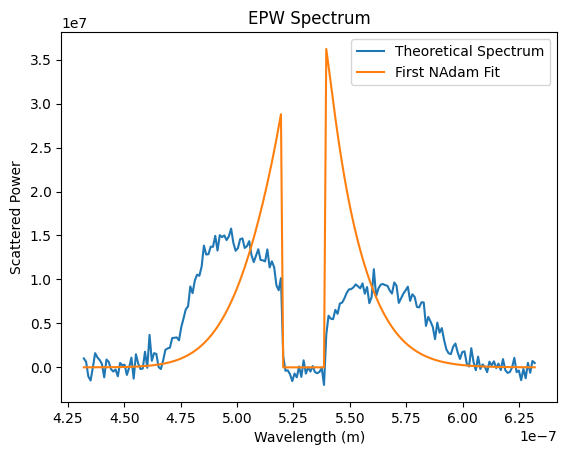

In [20]:
# Plot initial EPW S'
plt.plot(epw_wavelengths_TORCH.numpy(), epw_target, label="Theoretical Spectrum")
plt.plot(epw_wavelengths_TORCH.numpy(), Skw_arbdist_epw.detach().numpy(), label="First NAdam Fit")
plt.legend(loc="upper right")
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("EPW Spectrum")
plt.show()

## 3.3. Optimize EPW Spectrum

In [21]:


opt_epw = torch.optim.NAdam([
        {"params": (electron_params["ln_n"], electron_params["e_n1"], electron_params["e_n2"], electron_params["e_n3"], electron_params["e_n4"], electron_params["e_n5"], electron_params["e_n6"], electron_params["e_n7"], electron_params["e_n8"], electron_params["e_n9"], electron_params["e_n10"], electron_params["ln_e_T1"], electron_params["ln_e_T2"], electron_params["ln_e_T3"], electron_params["ln_e_T4"], electron_params["ln_e_T5"], electron_params["ln_e_T6"], electron_params["ln_e_T7"], electron_params["ln_e_T8"], electron_params["ln_e_T9"], electron_params["ln_e_T10"]),"lr":1e-3},
        {"params": (electron_params["e_vd1"], electron_params["e_vd2"], electron_params["e_vd3"], electron_params["e_vd4"], electron_params["e_vd5"], electron_params["e_vd6"], electron_params["e_vd7"], electron_params["e_vd8"], electron_params["e_vd9"], electron_params["e_vd10"]), "lr":100}
      ], lr=1e-3, betas=[0.9985, 0.999])




In [22]:
# Calculate initial EPW loss
epw_dist_hist = [Skw_arbdist_epw.detach().clone()]
epw_loss_hist = [float(dist_score(Skw_arbdist_epw, epw_target).detach())]
print(f"Initial EPW loss: {epw_loss_hist}")

Initial EPW loss: [174.6570738703552]


In [23]:
# Construct ion VDF now to save redundant calls
ifn = sum_of_maxwellians_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i0_T"]), ion_params["i0_vd"], torch.exp(ion_params["ln_i1_T"]),
                               ion_params["i1_vd"], torch.exp(ion_params["ln_i2_T"]), ion_params["i2_vd"], torch.exp(ion_params["ln_i3_T"]), ion_params["i3_vd"],
                               torch.exp(ion_params["ln_i4_T"]), ion_params["i4_vd"], torch.exp(ion_params["ln_i5_T"]), ion_params["i5_vd"], torch.exp(ion_params["ln_i6_T"]),
                               ion_params["i6_vd"], torch.exp(ion_params["ln_i7_T"]), ion_params["i7_vd"], torch.exp(ion_params["ln_i8_T"]), ion_params["i8_vd"],
                               torch.exp(ion_params["ln_i9_T"]), ion_params["i9_vd"], ion_params["i0_fract"],
                               ion_params["i1_fract"], ion_params["i2_fract"], ion_params["i3_fract"], ion_params["i4_fract"], ion_params["i5_fract"], ion_params["i6_fract"],
                               ion_params["i7_fract"], ion_params["i8_fract"], ion_params["i9_fract"])
ifn_epw = [ifn]

epw_counter = 0
while True:
#for i in trange(5000):
    opt_epw.zero_grad()

    # Reconstruct electron velocity distribution using updated parameters
    efn = sum_of_maxwellians_TORCH(e_velocity_axis_TORCH, torch.exp(electron_params["ln_e_T1"]), electron_params["e_vd1"],
                           torch.exp(electron_params["ln_e_T2"]), electron_params["e_vd2"], torch.exp(electron_params["ln_e_T3"]),
                           electron_params["e_vd3"], torch.exp(electron_params["ln_e_T4"]), electron_params["e_vd4"], torch.exp(electron_params["ln_e_T5"]),
                           electron_params["e_vd5"], torch.exp(electron_params["ln_e_T6"]), electron_params["e_vd6"], torch.exp(electron_params["ln_e_T7"]),
                           electron_params["e_vd7"], torch.exp(electron_params["ln_e_T8"]), electron_params["e_vd8"], torch.exp(electron_params["ln_e_T9"]),
                           electron_params["e_vd9"], torch.exp(electron_params["ln_e_T10"]), electron_params["e_vd10"],
                           electron_params["e_n1"], electron_params["e_n2"], electron_params["e_n3"], electron_params["e_n4"], electron_params["e_n5"],
                           electron_params["e_n6"], electron_params["e_n7"], electron_params["e_n8"], electron_params["e_n9"], electron_params["e_n10"])
    efn_epw = [efn]

    _, Skw_arbdist_epw = cpu_autodiff_thomson.spectral_density_arbdist(
    epw_wavelengths_TORCH,
    probe_wavelength_TORCH,
    e_velocity_axes_TORCH,
    i_velocity_axes_TORCH,
    efn_epw,
    ifn_epw,
    derivative_matrices,
    torch.exp(electron_params["ln_n"]),
    epw_notches,
    efract_TORCH,
    ifract_TORCH,
    ion_species_TORCH,
    probe_vec_TORCH,
    scatter_vec_TORCH,
    scattered_power_TORCH,
    inner_range=0.1,
    inner_frac=0.8,
    )

    # Caculate NMSE
    epw_loss = dist_score(Skw_arbdist_epw, epw_target)
    opt_epw.step()

    # Append value to loss history
    epw_dist_hist.append(Skw_arbdist_epw.detach().clone())
    epw_loss_hist.append(float(epw_loss.detach()))

    epw_counter += 1

    # Check if criteria of convergence is met
    delta_NMSE = abs(epw_loss_hist[epw_counter] - epw_loss_hist[epw_counter-1])
    if delta_NMSE <= EPW_CUTOFF_CRITERIA and epw_counter >= MIN_NUM_ITERS:
        n_TORCH = torch.exp(electron_params["ln_n"])
        print(f"Exiting loop after {epw_counter} iterations, loss is {delta_NMSE}")
        break

Exiting loop after 25707 iterations, loss is 2.1822215146016788e-09


Text(0.5, 1.0, 'EPW Loss History')

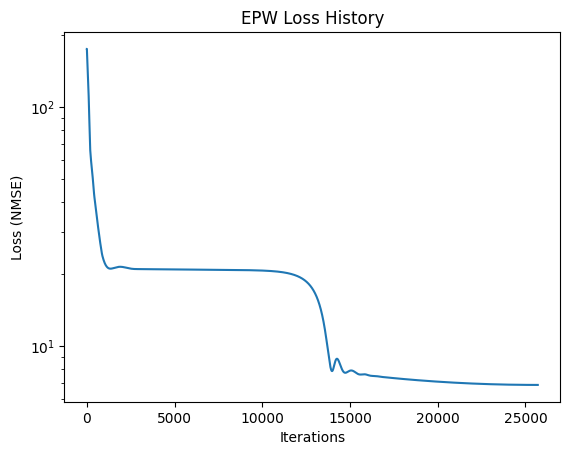

In [24]:
# Plot EPW loss history
plt.semilogy(epw_loss_hist)#[-100:])
plt.xlabel("Iterations")
plt.ylabel("Loss (NMSE)")
plt.title("EPW Loss History")

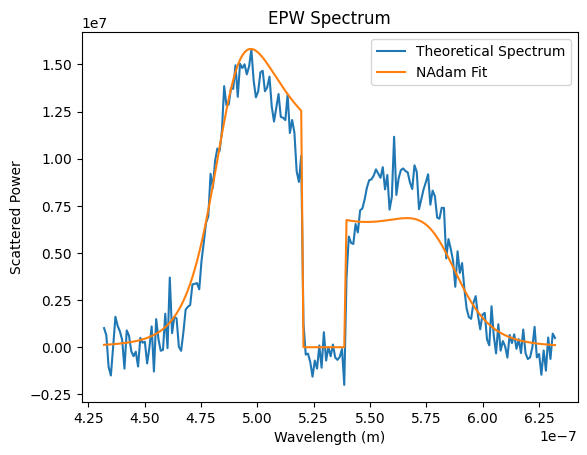

In [25]:
# Plot fitted EPW spectrum
plt.plot(epw_wavelengths_TORCH.numpy(), epw_target, label="Theoretical Spectrum")
plt.plot(epw_wavelengths_TORCH.numpy(), Skw_arbdist_epw.detach().numpy(), label="NAdam Fit")
plt.legend(loc = "upper right")
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("EPW Spectrum")
plt.show()

In [26]:
import torch
import torch.nn.functional as F

# --- Extract optimized temperature and drift parameters ---
e_T1_optim = torch.exp(electron_params["ln_e_T1"]).detach().clone()
e_vd1_optim = electron_params["e_vd1"].detach().clone()
e_T2_optim = torch.exp(electron_params["ln_e_T2"]).detach().clone()
e_vd2_optim = electron_params["e_vd2"].detach().clone()
e_T3_optim = torch.exp(electron_params["ln_e_T3"]).detach().clone()
e_vd3_optim = electron_params["e_vd3"].detach().clone()
e_T4_optim = torch.exp(electron_params["ln_e_T4"]).detach().clone()
e_vd4_optim = electron_params["e_vd4"].detach().clone()
e_T5_optim = torch.exp(electron_params["ln_e_T5"]).detach().clone()
e_vd5_optim = electron_params["e_vd5"].detach().clone()
e_T6_optim = torch.exp(electron_params["ln_e_T6"]).detach().clone()
e_vd6_optim = electron_params["e_vd6"].detach().clone()
e_T7_optim = torch.exp(electron_params["ln_e_T7"]).detach().clone()
e_vd7_optim = electron_params["e_vd7"].detach().clone()
e_T8_optim = torch.exp(electron_params["ln_e_T8"]).detach().clone()
e_vd8_optim = electron_params["e_vd8"].detach().clone()
e_T9_optim = torch.exp(electron_params["ln_e_T9"]).detach().clone()
e_vd9_optim = electron_params["e_vd9"].detach().clone()
e_T10_optim = torch.exp(electron_params["ln_e_T10"]).detach().clone()
e_vd10_optim = electron_params["e_vd10"].detach().clone()

# --- Stack and apply ReLU to weights ---
e_weights_raw = torch.stack([
    electron_params["e_n1"], electron_params["e_n2"], electron_params["e_n3"],
    electron_params["e_n4"], electron_params["e_n5"], electron_params["e_n6"],
    electron_params["e_n7"], electron_params["e_n8"], electron_params["e_n9"],
    electron_params["e_n10"]
])
e_weights_relu = F.relu(e_weights_raw)
e_weights_effective = e_weights_relu / e_weights_relu.sum()

# --- Store effective weights for reuse ---
(
    e_n1_optim, e_n2_optim, e_n3_optim, e_n4_optim, e_n5_optim,
    e_n6_optim, e_n7_optim, e_n8_optim, e_n9_optim, e_n10_optim
) = [w.detach().clone() for w in e_weights_effective]

# --- Print all parameters ---
for i in range(1, 11):
    print(f"e_T{i}:", locals()[f"e_T{i}_optim"])
    print(f"e_vd{i}:", locals()[f"e_vd{i}_optim"])
    print(f"effective_e_n{i}: {locals()[f'e_n{i}_optim'].item():.4f}")

# --- Print total density ---
n_optim = torch.exp(electron_params["ln_n"])
print("n:", n_optim)


e_T1: tensor([29.6465])
e_vd1: tensor([-422028.2428])
effective_e_n1: 0.0000
e_T2: tensor([135.2050])
e_vd2: tensor([-324132.8750])
effective_e_n2: 0.0000
e_T3: tensor([224.2431])
e_vd3: tensor([-225108.3321])
effective_e_n3: 0.0000
e_T4: tensor([309.0157])
e_vd4: tensor([-125948.9514])
effective_e_n4: 0.0000
e_T5: tensor([385.8931])
e_vd5: tensor([-28097.9426])
effective_e_n5: 0.0000
e_T6: tensor([522.1996])
e_vd6: tensor([81646.9951])
effective_e_n6: 0.0000
e_T7: tensor([744.0138])
e_vd7: tensor([198168.1012])
effective_e_n7: 0.0000
e_T8: tensor([1189.2870])
e_vd8: tensor([329572.3885])
effective_e_n8: 0.0000
e_T9: tensor([1345.3216])
e_vd9: tensor([934113.9486])
effective_e_n9: 0.0000
e_T10: tensor([519.5118])
e_vd10: tensor([-23787.0034])
effective_e_n10: 1.0000
n: tensor([6.9682e+24], grad_fn=<ExpBackward0>)


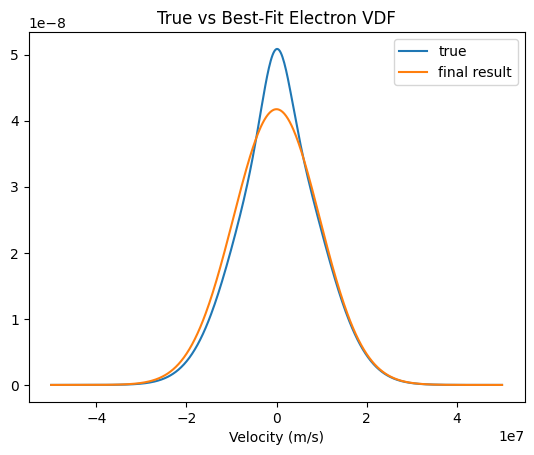

In [27]:
efn_optim = sum_of_maxwellians_TORCH(e_velocity_axis_TORCH, e_T1_optim, e_vd1_optim,
                           e_T2_optim, e_vd2_optim, e_T3_optim,
                           e_vd3_optim, e_T4_optim, e_vd4_optim, e_T5_optim,
                           e_vd5_optim, e_T6_optim, e_vd6_optim, e_T7_optim,
                           e_vd7_optim, e_T8_optim, e_vd8_optim, e_T9_optim,
                           e_vd9_optim, e_T10_optim, e_vd10_optim, e_n1_optim, e_n2_optim, e_n3_optim, e_n4_optim, e_n5_optim,
                           e_n6_optim, e_n7_optim, e_n8_optim, e_n9_optim, e_n10_optim)

plt.plot(e_velocity_axis_TORCH, fe_in, label='true')
plt.plot(e_velocity_axis_TORCH, efn_optim, label='final result')


plt.title('True vs Best-Fit Electron VDF')
plt.xlabel('Velocity (m/s)')
plt.legend()
plt.show()

## 3.4. Generate Initial IAW S'

In [28]:
# Enable gradient tracking for ion parameters
if NUM_FREE_PARAMS == NUM_PARAMS:
    for param in ion_params: ion_params[param].requires_grad=True
else:
    for i in range(NUM_FREE_PARAMS-NUM_ELECTRON_PARAMS): ion_params[ion_param_keys[i]].requires_grad=True

In [29]:
efn_optim = sum_of_maxwellians_TORCH(e_velocity_axis_TORCH, e_T1_optim, e_vd1_optim,
                           e_T2_optim, e_vd2_optim, e_T3_optim,
                           e_vd3_optim, e_T4_optim, e_vd4_optim, e_T5_optim,
                           e_vd5_optim, e_T6_optim, e_vd6_optim, e_T7_optim,
                           e_vd7_optim, e_T8_optim, e_vd8_optim, e_T9_optim,
                           e_vd9_optim, e_T10_optim, e_vd10_optim, e_n1_optim, e_n2_optim, e_n3_optim, e_n4_optim, e_n5_optim,
                           e_n6_optim, e_n7_optim, e_n8_optim, e_n9_optim, e_n10_optim)
efn_iaw = [efn_optim]

ifn = sum_of_maxwellians_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i0_T"]), ion_params["i0_vd"], torch.exp(ion_params["ln_i1_T"]),
                               ion_params["i1_vd"], torch.exp(ion_params["ln_i2_T"]), ion_params["i2_vd"], torch.exp(ion_params["ln_i3_T"]), ion_params["i3_vd"],
                               torch.exp(ion_params["ln_i4_T"]), ion_params["i4_vd"], torch.exp(ion_params["ln_i5_T"]), ion_params["i5_vd"], torch.exp(ion_params["ln_i6_T"]),
                               ion_params["i6_vd"], torch.exp(ion_params["ln_i7_T"]), ion_params["i7_vd"], torch.exp(ion_params["ln_i8_T"]), ion_params["i8_vd"],
                               torch.exp(ion_params["ln_i9_T"]), ion_params["i9_vd"], ion_params["i0_fract"],
                               ion_params["i1_fract"], ion_params["i2_fract"], ion_params["i3_fract"], ion_params["i4_fract"], ion_params["i5_fract"], ion_params["i6_fract"],
                               ion_params["i7_fract"], ion_params["i8_fract"], ion_params["i9_fract"])
ifn_iaw = [ifn]

# Call forward model function to generate initial IAW S'
_, Skw_arbdist_iaw = cpu_autodiff_thomson.spectral_density_arbdist(
    iaw_wavelengths_TORCH,
    probe_wavelength_TORCH,
    e_velocity_axes_TORCH,
    i_velocity_axes_TORCH,
    efn_iaw,
    ifn_iaw,
    derivative_matrices,
    n_optim,
    iaw_notch,
    efract_TORCH,
    ifract_TORCH,
    ion_species_TORCH,
    probe_vec_TORCH,
    scatter_vec_TORCH,
    scattered_power_TORCH,
    inner_range=0.1,
    inner_frac=0.8,
)

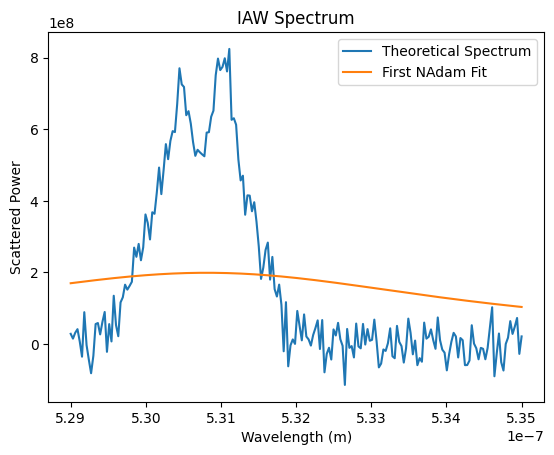

In [30]:
# Plot initial IAW S'
plt.plot(iaw_wavelengths_TORCH.numpy(), iaw_target, label="Theoretical Spectrum")
plt.plot(iaw_wavelengths_TORCH.numpy(), Skw_arbdist_iaw.detach().numpy(), label="First NAdam Fit")
plt.legend(loc = "upper right")
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("IAW Spectrum")
plt.show()

## 3.5. Optimize IAW Spectrum

In [31]:
opt_iaw = torch.optim.NAdam([
        {"params": ( ion_params["i0_fract"], ion_params["i1_fract"], ion_params["i2_fract"], ion_params["i3_fract"], ion_params["i4_fract"], ion_params["i5_fract"], ion_params["i6_fract"], ion_params["i7_fract"], ion_params["i8_fract"], ion_params["i9_fract"], ion_params["ln_i0_T"], ion_params["ln_i1_T"], ion_params["ln_i2_T"], ion_params["ln_i3_T"], ion_params["ln_i4_T"], ion_params["ln_i5_T"], ion_params["ln_i6_T"], ion_params["ln_i7_T"], ion_params["ln_i8_T"], ion_params["ln_i9_T"]),"lr":1e-3},
        {"params": (ion_params["i0_vd"], ion_params["i1_vd"], ion_params["i2_vd"], ion_params["i3_vd"], ion_params["i4_vd"], ion_params["i5_vd"], ion_params["i6_vd"], ion_params["i7_vd"], ion_params["i8_vd"], ion_params["i9_vd"]), "lr":100}
      ], lr=1e-3, betas=[0.9985, 0.999])


In [32]:
# Calculate initial IAW loss
iaw_dist_hist = [Skw_arbdist_iaw.detach().clone()]
iaw_loss_hist = [float(dist_score(Skw_arbdist_iaw, iaw_target).detach())]
print(f"Initial IAW Loss: {iaw_loss_hist}")

Initial IAW Loss: [85.21818045285008]


In [33]:
# Construct fitted electron VDF now to save redundant calls
efn_optim = sum_of_maxwellians_TORCH(e_velocity_axis_TORCH, e_T1_optim, e_vd1_optim,
                           e_T2_optim, e_vd2_optim, e_T3_optim,
                           e_vd3_optim, e_T4_optim, e_vd4_optim, e_T5_optim,
                           e_vd5_optim, e_T6_optim, e_vd6_optim, e_T7_optim,
                           e_vd7_optim, e_T8_optim, e_vd8_optim, e_T9_optim,
                           e_vd9_optim, e_T10_optim, e_vd10_optim, e_n1_optim, e_n2_optim, e_n3_optim, e_n4_optim, e_n5_optim,
                           e_n6_optim, e_n7_optim, e_n8_optim, e_n9_optim, e_n10_optim)
efn_iaw = [efn_optim]

iaw_counter = 0
while True:
#for i in trange(3000):
    opt_iaw.zero_grad()

    # Reconstruct ion velocity distribution using updated parameters
    ifn = sum_of_maxwellians_TORCH(i_velocity_axis_TORCH, torch.exp(ion_params["ln_i0_T"]), ion_params["i0_vd"], torch.exp(ion_params["ln_i1_T"]),
                               ion_params["i1_vd"], torch.exp(ion_params["ln_i2_T"]), ion_params["i2_vd"], torch.exp(ion_params["ln_i3_T"]), ion_params["i3_vd"],
                               torch.exp(ion_params["ln_i4_T"]), ion_params["i4_vd"], torch.exp(ion_params["ln_i5_T"]), ion_params["i5_vd"], torch.exp(ion_params["ln_i6_T"]),
                               ion_params["i6_vd"], torch.exp(ion_params["ln_i7_T"]), ion_params["i7_vd"], torch.exp(ion_params["ln_i8_T"]), ion_params["i8_vd"],
                               torch.exp(ion_params["ln_i9_T"]), ion_params["i9_vd"], ion_params["i0_fract"],
                               ion_params["i1_fract"], ion_params["i2_fract"], ion_params["i3_fract"], ion_params["i4_fract"], ion_params["i5_fract"], ion_params["i6_fract"],
                               ion_params["i7_fract"], ion_params["i8_fract"], ion_params["i9_fract"])
    ifn_iaw = [ifn]

    _, Skw_arbdist_iaw = cpu_autodiff_thomson.spectral_density_arbdist(
    iaw_wavelengths_TORCH,
    probe_wavelength_TORCH,
    e_velocity_axes_TORCH,
    i_velocity_axes_TORCH,
    efn_iaw,
    ifn_iaw,
    derivative_matrices,
    n_optim,
    iaw_notch,
    efract_TORCH,
    ifract_TORCH,
    ion_species_TORCH,
    probe_vec_TORCH,
    scatter_vec_TORCH,
    scattered_power_TORCH,
    inner_range=0.1,
    inner_frac=0.8,
    )

    # Caculate NMSE
    iaw_loss = dist_score(Skw_arbdist_iaw, iaw_target.detach())

    opt_iaw.step()

    # Append value to loss history
    iaw_dist_hist.append(Skw_arbdist_iaw.detach().clone())
    iaw_loss_hist.append(float(iaw_loss.detach()))

    iaw_counter += 1

    # Check if criteria of convergence is met
    delta_NMSE = abs(iaw_loss_hist[iaw_counter] - iaw_loss_hist[iaw_counter-1])
    if delta_NMSE <= IAW_CUTOFF_CRITERIA and iaw_counter >= MIN_NUM_ITERS:
        print(f"Exiting loop after {iaw_counter} iterations, loss is {delta_NMSE}")
        break

Exiting loop after 5643 iterations, loss is 4.993898627958515e-09


Text(0.5, 1.0, 'IAW Loss History')

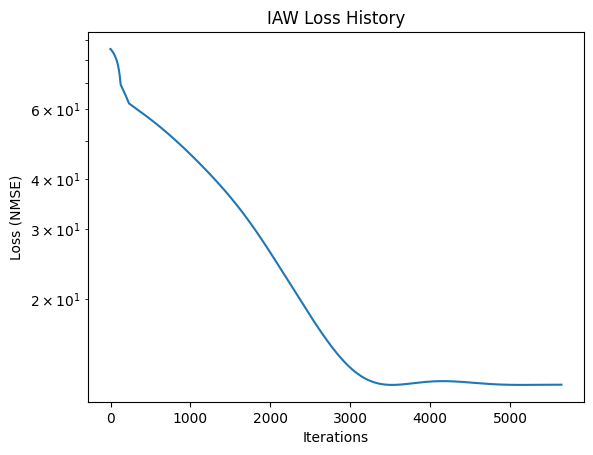

In [34]:
# Plot IAW loss history
plt.semilogy(iaw_loss_hist)#[-100:])
plt.xlabel("Iterations")
plt.ylabel("Loss (NMSE)")
plt.title("IAW Loss History")

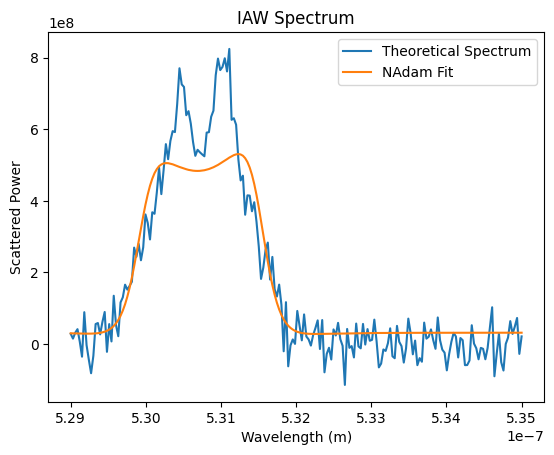

In [35]:
# Plot fitted IAW spectrum
plt.plot(iaw_wavelengths_TORCH.numpy(), iaw_target, label="Theoretical Spectrum")
plt.plot(iaw_wavelengths_TORCH.numpy(), Skw_arbdist_iaw.detach().numpy(), label="NAdam Fit")
plt.legend(loc="upper right")
plt.xlabel("Wavelength (m)")
plt.ylabel("Scattered Power")
plt.title("IAW Spectrum")
plt.show()

In [36]:
import torch
import torch.nn.functional as F

# Extract optimized ion temperatures (de-log) and drift velocities
i0_T_optim = torch.exp(ion_params["ln_i0_T"]).detach().clone()
i1_T_optim = torch.exp(ion_params["ln_i1_T"]).detach().clone()
i2_T_optim = torch.exp(ion_params["ln_i2_T"]).detach().clone()
i3_T_optim = torch.exp(ion_params["ln_i3_T"]).detach().clone()
i4_T_optim = torch.exp(ion_params["ln_i4_T"]).detach().clone()
i5_T_optim = torch.exp(ion_params["ln_i5_T"]).detach().clone()
i6_T_optim = torch.exp(ion_params["ln_i6_T"]).detach().clone()
i7_T_optim = torch.exp(ion_params["ln_i7_T"]).detach().clone()
i8_T_optim = torch.exp(ion_params["ln_i8_T"]).detach().clone()
i9_T_optim = torch.exp(ion_params["ln_i9_T"]).detach().clone()

i0_vd_optim = ion_params["i0_vd"].detach().clone()
i1_vd_optim = ion_params["i1_vd"].detach().clone()
i2_vd_optim = ion_params["i2_vd"].detach().clone()
i3_vd_optim = ion_params["i3_vd"].detach().clone()
i4_vd_optim = ion_params["i4_vd"].detach().clone()
i5_vd_optim = ion_params["i5_vd"].detach().clone()
i6_vd_optim = ion_params["i6_vd"].detach().clone()
i7_vd_optim = ion_params["i7_vd"].detach().clone()
i8_vd_optim = ion_params["i8_vd"].detach().clone()
i9_vd_optim = ion_params["i9_vd"].detach().clone()

# Stack and apply ReLU + normalize to get non-negative fractions
i_fracts_raw = torch.stack([
    ion_params["i0_fract"], ion_params["i1_fract"], ion_params["i2_fract"],
    ion_params["i3_fract"], ion_params["i4_fract"], ion_params["i5_fract"],
    ion_params["i6_fract"], ion_params["i7_fract"], ion_params["i8_fract"],
    ion_params["i9_fract"]
])
i_fracts_relu = F.relu(i_fracts_raw)
i_fracts_normalized = i_fracts_relu / i_fracts_relu.sum()

# Assign to individual variables
(
    i0_fract_optim, i1_fract_optim, i2_fract_optim, i3_fract_optim, i4_fract_optim,
    i5_fract_optim, i6_fract_optim, i7_fract_optim, i8_fract_optim, i9_fract_optim
) = [w.detach().clone() for w in i_fracts_normalized]

# Print to console for reference
print("i0_T:", i0_T_optim)
print("i1_T:", i1_T_optim)
print("i2_T:", i2_T_optim)
print("i3_T:", i3_T_optim)
print("i4_T:", i4_T_optim)
print("i5_T:", i5_T_optim)
print("i6_T:", i6_T_optim)
print("i7_T:", i7_T_optim)
print("i8_T:", i8_T_optim)
print("i9_T:", i9_T_optim)

print("i0_vd:", i0_vd_optim)
print("i1_vd:", i1_vd_optim)
print("i2_vd:", i2_vd_optim)
print("i3_vd:", i3_vd_optim)
print("i4_vd:", i4_vd_optim)
print("i5_vd:", i5_vd_optim)
print("i6_vd:", i6_vd_optim)
print("i7_vd:", i7_vd_optim)
print("i8_vd:", i8_vd_optim)
print("i9_vd:", i9_vd_optim)

print("i0_fract:", i0_fract_optim)
print("i1_fract:", i1_fract_optim)
print("i2_fract:", i2_fract_optim)
print("i3_fract:", i3_fract_optim)
print("i4_fract:", i4_fract_optim)
print("i5_fract:", i5_fract_optim)
print("i6_fract:", i6_fract_optim)
print("i7_fract:", i7_fract_optim)
print("i8_fract:", i8_fract_optim)
print("i9_fract:", i9_fract_optim)


i0_T: tensor([0.1394])
i1_T: tensor([3.7450])
i2_T: tensor([6.9558])
i3_T: tensor([9.1628])
i4_T: tensor([11.4968])
i5_T: tensor([13.8605])
i6_T: tensor([16.2459])
i7_T: tensor([18.6560])
i8_T: tensor([21.0989])
i9_T: tensor([23.5907])
i0_vd: tensor([505146.6219])
i1_vd: tensor([493818.4595])
i2_vd: tensor([488073.9309])
i3_vd: tensor([504352.2773])
i4_vd: tensor([518244.5704])
i5_vd: tensor([531717.2568])
i6_vd: tensor([545034.0766])
i7_vd: tensor([558273.5776])
i8_vd: tensor([571470.7801])
i9_vd: tensor([584638.5977])
i0_fract: tensor([1.])
i1_fract: tensor([0.])
i2_fract: tensor([0.])
i3_fract: tensor([0.])
i4_fract: tensor([0.])
i5_fract: tensor([0.])
i6_fract: tensor([0.])
i7_fract: tensor([0.])
i8_fract: tensor([0.])
i9_fract: tensor([0.])


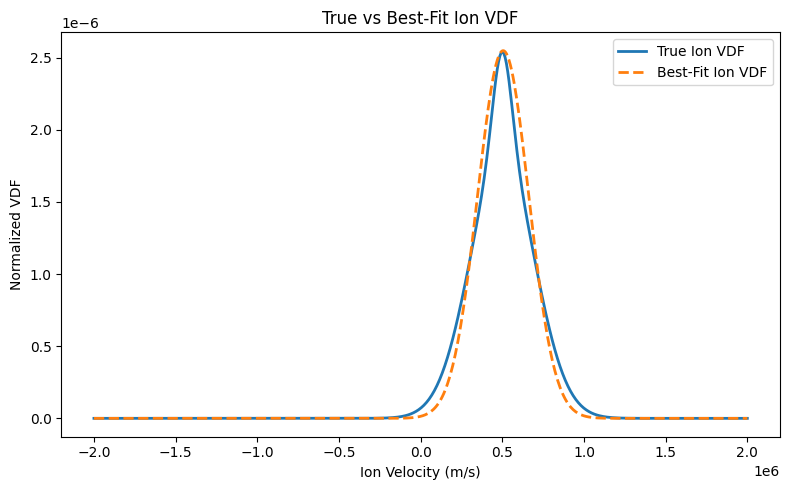

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- Define true ion VDFs ---
def maxwellian_H(v, T, vd):
    T_K = T * 11605
    vth = np.sqrt(2 * 1.5156e7 * T_K / 1836)
    exp_term = -(v - vd) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

def maxwellian_C(v, T, vd):
    T_K = T * 11605
    vth = np.sqrt(2 * 1.5156e7 * T_K / (1836 * 12))  # Correct reduced mass for C
    exp_term = -(v - vd) ** 2 / (vth ** 2)
    return np.exp(exp_term) / np.sqrt(np.pi * vth ** 2)

# --- Define velocity axis (same one used in fitting) ---
vi = i_velocity_axis_TORCH.detach().cpu().numpy()

# --- Individual contributions ---
fH = maxwellian_H(vi, 400, 5.0e5)
fC = maxwellian_C(vi, 400, 5.0e5)
fH_weighted = (9/10) * fH
fC_weighted = (1/10) * fC
true_ifn = fH_weighted + fC_weighted

# --- Best-fit VDF ---
ion_optimized_vdf = sum_of_maxwellians_TORCH(
    i_velocity_axis_TORCH,
    i0_T_optim, i0_vd_optim,
    i1_T_optim, i1_vd_optim,
    i2_T_optim, i2_vd_optim,
    i3_T_optim, i3_vd_optim,
    i4_T_optim, i4_vd_optim,
    i5_T_optim, i5_vd_optim,
    i6_T_optim, i6_vd_optim,
    i7_T_optim, i7_vd_optim,
    i8_T_optim, i8_vd_optim,
    i9_T_optim, i9_vd_optim,
    i0_fract_optim,
    i1_fract_optim,
    i2_fract_optim,
    i3_fract_optim,
    i4_fract_optim,
    i5_fract_optim,
    i6_fract_optim,
    i7_fract_optim,
    i8_fract_optim,
    i9_fract_optim
)


# --- Plotting ---
plt.figure(figsize=(8, 5))
plt.plot(vi, true_ifn, label='True Ion VDF', linewidth=2)
plt.plot(vi, ion_optimized_vdf, label='Best-Fit Ion VDF', linestyle='--', linewidth=2)



plt.xlabel('Ion Velocity (m/s)')
plt.ylabel('Normalized VDF')
plt.title('True vs Best-Fit Ion VDF')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()
